<a href="https://colab.research.google.com/github/poorya-abbasi/DL-HW05/blob/main/Poorya's_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Dependencies

In [3]:
import numpy as np
import math   
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from os import listdir
from os.path import isfile, join

#Mounting To Google Drive

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Preparing Data

In [ ]:
dataPath="/content/drive/MyDrive/DL_Dataset/FinalProjectMat/"
noteNames = [f[:-4] for f in listdir(dataPath+"/piano_triads") if isfile(join(dataPath+"/piano_triads", f))]
artifcatNames = [f[:-4] for f in listdir(dataPath+"/artifacts") if isfile(join(dataPath+"/artifacts", f))]
artifacts = list()
print("Note Source Count : ",len(noteNames))
print("Artifact Source Count : ",len(artifcatNames))

#Combining Random N Notes Together

In [10]:
from random import randint
import librosa
import os.path
import soundfile as sf

global_sample_rate = 2756

def combineRandomNotes(n, filename="generated.wav"):
  basePath = dataPath+"piano_triads/"
  outputPath = dataPath;
  selectedNotes = list()
  min = 0
  max = len(noteNames)
  for i in range(0,n):
    rnd = randint(min,max-1)
    selectedNotes.append(noteNames[rnd])
  print(selectedNotes)
  for i in range(0,len(selectedNotes)):
    selectedNotes[i], sr=librosa.load(basePath+selectedNotes[i]+'.wav', sr=global_sample_rate)
  data = np.concatenate(selectedNotes)
  sf.write(outputPath+filename, data, global_sample_rate, 'PCM_16')
  return data

#Adding Noise To Sounds
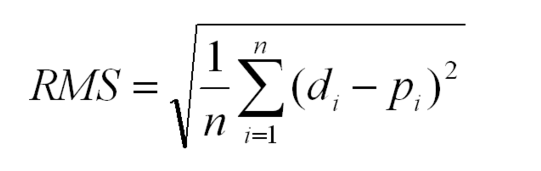

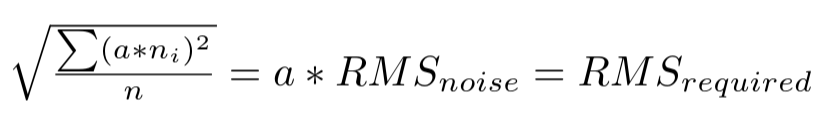

In [ ]:
def readAndKeepAllArtificatsInMemory():
  basePath = dataPath+"artifacts/"
  for i in range(0,len(artifcatNames)):
    data,sr=librosa.load(basePath+artifcatNames[i]+'.wav', sr=global_sample_rate)
    artifacts.append(data)
    
def getArtifactAtIndex(i,input,chunk = -1):
  #Tuple Including Data Matrix And Sample Rate
  length = input.shape[0]/global_sample_rate
  currentLen = 0
  selectedArtifacts = list()
  #Combining Random Noises Until The Whole Duration Of The Sound File Is Covered
  while currentLen < length:
    data = artifacts[i]
    selectedArtifacts.append(data)
    artifactLength = data.shape[0]/global_sample_rate
    currentLen += artifactLength
  if(len(selectedArtifacts)>0):
    result = np.concatenate(selectedArtifacts)
  else:
    result = selectedArtifacts[0]
  #Making Artifacts The Same Length As The Source
  if chunk >= 0:
    result = result[len(input)*chunk:len(input)*(chunk+1)]
  elif(len(input)<len(result)):
    result = result[0:len(input)]
  return result

def calcArtifactBasedOnSource(data,artifact,ratio):
  #Calculate The RMS Of Source File
  DataRMS=math.sqrt(np.mean(data**2))
  ArtifactRMS=math.sqrt(DataRMS**2/(pow(10,ratio/10)))  
  CurrentRMS=math.sqrt(np.mean(artifact**2))
  artifact=artifact*(ArtifactRMS/CurrentRMS)
  return artifact

def applyArtifactToSource(data,artifact,ratio):
  artifact = calcArtifactBasedOnSource(data,artifact,ratio)
  output = data + artifact
  return output

if(len(artifacts) < 1):
  readAndKeepAllArtificatsInMemory()
  print("Loaded artifacts into memory : "+str(len(artifacts)))

#Clip Generation and Noise Application

In [25]:
#Generating a 3 note clip
numberOfNotes = 3
# generated_data = combineRandomNotes(numberOfNotes)
# Applying noise to the generated clip
# artifact = getArtifactAtIndex(0,generated_data)
# sf.write(dataPath+"generated_noised.wav",applyArtifactToSource(generated_data,artifact,10),global_sample_rate)

def divideSourceByChunks(source,time = 3):
  currentChunk = 0
  result = list()
  chunks = int(len(source)/(global_sample_rate * time))
  for i in range(0,chunks):
    x = source[global_sample_rate*i:global_sample_rate*(i+1)]
    result.append(x)
  return result

def addPaddingToSource(source, goal=90):
  sourceLen = len(source)/global_sample_rate
  diff = 90 - sourceLen
  dimen = int(diff * global_sample_rate)
  padding = np.zeros((dimen,))
  output = np.concatenate([source,padding])
  return output

# divided = divideSourceByChunks(generated_data,3)
addPaddingToSource(np.ones((82680,)))

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
def generateNoisedNotes(min,max):
  result = list()
  basePath = dataPath+"piano_triads_2756/"
  for x in range(min,max):
    forEachArtifact = list()
    outputPath = dataPath+"noise_applied/"+artifcatNames[x]+"/"
    if(not os.path.exists(dataPath+"noise_applied/")):
      os.mkdir(dataPath+"noise_applied/")
    if(not os.path.exists(outputPath)):
      os.mkdir(outputPath)
    for i in range(0,len(noteNames)):
      data,sr = sf.read(basePath+noteNames[i]+".wav")
      for j in range(0,3):
        artifact = getArtifactAtIndex(x,data,chunk=j)
        output = applyArtifactToSource(data,artifact,0.5)
        filename = "audio_"+noteNames[i]+"_chunk_"+str(j+1)+".wav"
        sf.write(outputPath+filename, output, sr, 'PCM_16')
        forEachArtifact.append(output)
    result.append(forEachArtifact)
    print("Proccessing done for artifact",x)
  return result

# generateNoisedNotes(0,len(artifcatNames))
#Noised is a 2D list in which the first dimension is artifact category and the second dimension is source sound
#To access all the sounds generated by artifact 6 you can use noised[6] and to access sound 7 of artifact 6 you can use noised[6][7]
noisedNotes = generateNoisedNotes(0,len(artifcatNames))